<a href="https://colab.research.google.com/github/stxupengyu/NCF-for-Implicit-Feedback/blob/main/MIND_NCF_Large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Link Google Drive

In [ ]:
#link google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#enter the folder
!ls
import os
os.chdir('/content/drive/My Drive/Project/NCF')
!ls

behaviors.tsv	      MIND_NCF.ipynb	    rating.csv
best_model.h5	      MIND_NCF_Large.ipynb  relation_embedding.vec
entity_embedding.vec  news.tsv		    微信图片_20201215094157.jpg
behaviors.tsv	      MIND_NCF.ipynb	    rating.csv
best_model.h5	      MIND_NCF_Large.ipynb  relation_embedding.vec
entity_embedding.vec  news.tsv		    微信图片_20201215094157.jpg


#Read Data

In [ ]:
#config
sample_num = 100#negative sample numbers
n_factors = 30#embedding dim
batch_size = 64
epochs = 2

In [ ]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
def show_data(data_path):
  '''
  show data by row
  input: data_path
  output: print the top 3 rows
  '''
  print('===================================')
  print(data_path)
  iFile = open(data_path, "r")
  count = 0
  for line in iFile.readlines():
    print(line)
    if count>2:
      break
    count+= 1
  
show_data('behaviors.tsv')
show_data('news.tsv')
show_data('entity_embedding.vec')
show_data('relation_embedding.vec')

behaviors.tsv
1	U13740	11/11/2019 9:05:58 AM	N55189 N42782 N34694 N45794 N18445 N63302 N10414 N19347 N31801	N55689-1 N35729-0

2	U91836	11/12/2019 6:11:30 PM	N31739 N6072 N63045 N23979 N35656 N43353 N8129 N1569 N17686 N13008 N21623 N6233 N14340 N48031 N62285 N44383 N23061 N16290 N6244 N45099 N58715 N59049 N7023 N50528 N42704 N46082 N8275 N15710 N59026 N8429 N30867 N56514 N19709 N31402 N31741 N54889 N9798 N62612 N2663 N16617 N6087 N13231 N63317 N61388 N59359 N51163 N30698 N34567 N54225 N32852 N55833 N64467 N3142 N13912 N29802 N44462 N29948 N4486 N5398 N14761 N47020 N65112 N31699 N37159 N61101 N14761 N3433 N10438 N61355 N21164 N22976 N2511 N48390 N58224 N48742 N35458 N24611 N37509 N21773 N41011 N19041 N25785	N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N22407-0 N14592-0 N17059-1 N33677-0 N7821-0 N6890-0

3	U73700	11/14/2019 7:01:48 AM	N10732 N25792 N7563 N21087 N41087 N5445 N60384 N46616 N52500 N33164 N47289 N24233 N62058 N26378 N49475 N18870	N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 

In [ ]:
def read_data(data_path):
  '''
  read data by row
  input: data_path
  output: two feature u need
  '''
  print('===================================')
  print(data_path)
  iFile = open(data_path, "r")
  count = 0
  row_0 = []
  row_1 = []
  for line in iFile.readlines():
    lineVec = line.strip().split('\t')#split by '\t'
    row_0.append(lineVec[1])
    row_1.append(lineVec[3])
    count+= 1
  print('Length of Current Data:',len(row_0))
  return row_0,row_1 
  
user_str, item_str = read_data('behaviors.tsv')

behaviors.tsv
Length of Current Data: 156965


#Pre-processing Data

In [ ]:
def raw2DataFrame(user_str, item_str):
  '''
  convert original raw data to DataFrame Format
  input: user_str, item_str
  output: DataFrame, eg:[[user,item,rating]...]
  '''  
  record = []
  for i in range(len(user_str)):
    if item_str[i]!='':
      temp_item_list = item_str[i].strip().split(' ')
      for temp_item in temp_item_list:
        record.append([user_str[i], temp_item, 5])
  print('The Sample Size:',len(record))
  index_data = pd.DataFrame(record)
  display(index_data.tail(2))
  return index_data
index_data = raw2DataFrame(user_str, item_str)

The Sample Size: 5107639


,0,1,2
5107637,U64800,N22997,5
5107638,U64800,N48742,5


In [ ]:
def index2number(index_data):
  '''
  convert id to number
  input: index_data, eg:[[N45,N5456,1]...]
  output: index_data, eg:[[45,5456,1]...]
  '''  
  dictionary_user=dict(zip(list(index_data[0].drop_duplicates().values), range(len(index_data[0].drop_duplicates().values))))
  dictionary_business=dict(zip(list(index_data[1].drop_duplicates().values), range(len(index_data[1].drop_duplicates().values))))
  user_set=[]
  for user in index_data[0]:
    user_set.append(dictionary_user[user])#+1
  business_set=[]
  for business in index_data[1]:
    business_set.append(dictionary_business[business])#+1
  index_data[0]=user_set
  index_data[1]=business_set
  user_num = max(user_set)
  item_num = max(business_set)
  print('Max user:%d,Max item:%d'%(user_num,item_num))
  display(index_data.tail(2))
  return index_data, user_num, item_num
index_data, user_num, item_num = index2number(index_data)

Max user:49107,Max item:33194


,0,1,2
5107637,13031,1754,5
5107638,13031,82,5


In [ ]:
def sample_neg(index_data, user_num, item_num, sample_num, user_item_dict):
  '''
  negative sampling
  input: index_data, user_num, item_num, eg:[[45,5456,1]...]
  output: negative_index_data, eg:[[45,5455,0]...] 
  '''
  record_neg = []
  for user in range(user_num):
    user_id = user
    original_sample = user_item_dict[user_id]
    temp_sample = np.random.choice(range(item_num), size = sample_num)
    final_sample = list(set(temp_sample) - set(original_sample))
    for item in final_sample:
      record_neg.append([user_id, item, 3])
  print('The Negative Sample Size:',len(record_neg))
  neg_data = pd.DataFrame(record_neg)
  display(neg_data.tail(2))  
  return neg_data
  
user_item_dict = index_data.groupby(0).groups
neg_data = sample_neg(index_data, user_num, item_num, sample_num, user_item_dict)

The Negative Sample Size: 4903250


,0,1,2
4903248,49106,14333,3
4903249,49106,30975,3


In [ ]:
#Save Data
final_data = pd.concat([index_data, neg_data], axis = 0)
final_data = shuffle(final_data)
display(final_data.tail(2))
#store the dataset and then read it 
final_data.to_csv('rating.csv',header=-1,index=0)
print('Data Saved')

,0,1,2
2109982,21132,25727,3
3883890,1557,3177,5


Data Saved


#NCF

In [ ]:
data = pd.read_csv('rating.csv')
display(data.tail(2))

,0,1,2
10010887,21132,25727,3
10010888,1557,3177,5


In [ ]:
n_users, n_rests, max_rating = data.iloc[:,:3].max()
min_rating = data.iloc[:,2].min()

In [ ]:
from sklearn.model_selection import train_test_split

X = data[['0','1']].values
y = data['2'].values

X_train_keras, X_test_keras, y_train_keras, y_test_keras = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_keras.shape, X_test_keras.shape, y_train_keras.shape, y_test_keras.shape

((9009800, 2), (1001089, 2), (9009800,), (1001089,))

In [ ]:
X_train_array = [X_train_keras[:, 0], X_train_keras[:, 1]]
X_test_array = [X_test_keras[:, 0], X_test_keras[:, 1]]

In [ ]:
from keras.layers import Add, Activation, Lambda
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        
        return x
    
def Recommender(n_users, n_rests, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    restaurant = Input(shape=(1,))
    m = EmbeddingLayer(n_rests, n_factors)(restaurant)
    mb = EmbeddingLayer(n_rests, 1)(restaurant)   
    
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)  
    
    model = Model(inputs=[user, restaurant], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae','mse'])  
    
    return model

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint, EarlyStopping

#save best model 
model_name='best_model.h5'
es = EarlyStopping(monitor='val_loss', patience=2)
cp = ModelCheckpoint(filepath=model_name, monitor='val_loss', save_best_only=True)
keras_model = Recommender(int(n_users)+1, int(n_rests)+1, n_factors, min_rating, max_rating)
keras_model.summary()
history = keras_model.fit(x=X_train_array, y=y_train_keras, batch_size=batch_size,\
      epochs=epochs, verbose=1, callbacks=[es, cp], validation_data=(X_test_array, y_test_keras))


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 30)        1473240     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 30)        995850      input_4[0][0]                    
_______________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


140779/140779 [==============================] - 1671s 12ms/step - loss: 0.4390 - mae: 0.4872 - mse: 0.3855 - val_loss: 0.3927 - val_mae: 0.4339 - val_mse: 0.3308
Epoch 2/2
140779/140779 [==============================] - 1670s 12ms/step - loss: 0.3928 - mae: 0.4326 - mse: 0.3313 - val_loss: 0.3935 - val_mae: 0.4320 - val_mse: 0.3322


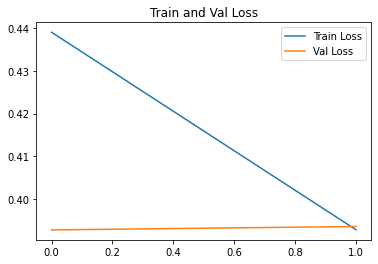

mae,rmse: 0.6576805691322429 0.8746973094819743


In [ ]:
#iter plot
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()
#load best model
keras_model.load_weights(model_name)  
y_pred = keras_model.predict(X_test_array)
mae = mean_absolute_error(y_test_keras, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_keras, y_pred))
print('mae,rmse:',mae,rmse)